In [33]:
import re
import time
import math
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA

# Amazon Review Sentiment Analysis

In this project we will test several models to predict if an Amazon review is negative or positive and then select the best one. We will the test the best model and see if it can make similar prediction on other category reviews

In [34]:
# Load the data
amazon = pd.read_json('C:/Users/keith/Desktop/Thinkful/Patio_Lawn_and_Garden_5.json', lines=True)
 
pd.set_option('display.max_columns', None) # disables trucated columns 
pd.set_option('display.max_rows', None) # disables trucated rows


In [35]:
amazon.shape

(13272, 9)

In [36]:
amazon.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002N674,"[4, 4]",4,Good USA company that stands behind their prod...,"06 21, 2011",A1JZFGZEZVWQPY,"Carter H ""1amazonreviewer@gmail . com""",Great Hoses,1308614400
1,B00002N674,"[0, 0]",5,This is a high quality 8 ply hose. I have had ...,"06 9, 2014",A32JCI4AK2JTTG,"Darryl Bennett ""Fuzzy342""",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,1402272000
2,B00002N674,"[2, 3]",4,It's probably one of the best hoses I've ever ...,"05 5, 2012",A3N0P5AAMP6XD2,H B,Very satisfied!,1336176000
3,B00002N674,"[0, 0]",5,I probably should have bought something a bit ...,"07 15, 2013",A2QK7UNJ857YG,Jason,Very high quality,1373846400
4,B00002N674,"[1, 1]",5,I bought three of these 5/8-inch Flexogen hose...,"08 5, 2013",AS0CYBAN6EM06,jimmy,Good Hoses,1375660800


## Data Description
This dataset is a small collection of reviews on Patio, Lawn and Garden purchased from Amazon.com. It was downloaded from http://jmcauley.ucsd.edu/data/amazon/. there are 9 columns and 13272 reviews. 

## Data Cleaning

In [37]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13272 entries, 0 to 13271
Data columns (total 9 columns):
asin              13272 non-null object
helpful           13272 non-null object
overall           13272 non-null int64
reviewText        13272 non-null object
reviewTime        13272 non-null object
reviewerID        13272 non-null object
reviewerName      13107 non-null object
summary           13272 non-null object
unixReviewTime    13272 non-null int64
dtypes: int64(2), object(7)
memory usage: 933.3+ KB


In [38]:
amazon.isnull().sum()

asin                0
helpful             0
overall             0
reviewText          0
reviewTime          0
reviewerID          0
reviewerName      165
summary             0
unixReviewTime      0
dtype: int64

Only one column has null values. It is it the column that contains the name of the reviewer. This columns is not going to be used for our purposes so there is no action needed to be taken.

In [39]:
# count of each class of ratings
amazon.overall.value_counts()

5    7037
4    3384
3    1659
2     673
1     519
Name: overall, dtype: int64

We will create a binary rating feature where anything under a "5" rating is considered negative and will be classed as "0". All the "5" ratings will be positive and classed as a "1".

In [40]:
# create binary ratings feature
amazon['catgry_rate'] = np.where(amazon.overall<5,0,1)
amazon.catgry_rate.value_counts()

1    7037
0    6235
Name: catgry_rate, dtype: int64

The 'unixReviewTime' column isn't very useful and will be converted into datetime. We will also conver the "reviewTime" columns as well.

In [41]:
# convert to datetime
amazon['unixReviewTime'] = pd.to_datetime(amazon.unixReviewTime ,unit='s')
amazon.unixReviewTime.head(2)

0   2011-06-21
1   2014-06-09
Name: unixReviewTime, dtype: datetime64[ns]

In [42]:
amazon['reviewTime'] = pd.to_datetime(amazon.reviewTime)
amazon.reviewTime.head(2)

0   2011-06-21
1   2014-06-09
Name: reviewTime, dtype: datetime64[ns]

In [43]:
# create a feature that stores the lenth of each review
review_length = []
for i in amazon.reviewText:     
         review_length.append(len(i))
amazon['review_length'] = review_length

In [44]:
print(amazon[amazon.catgry_rate==1].review_length.mean())
print(amazon[amazon.catgry_rate==0].review_length.mean())

750.440102316328
959.2368885324779


In [45]:
# check correlation with lenth of review and rating
amazon.catgry_rate.corr(amazon.review_length)

-0.12628107998519295

There seems to be a negative correlation between the lenth of a review and the rating of that review which would imply that the longer the review the more negative the rating. It is a weak correlation but worth noting.

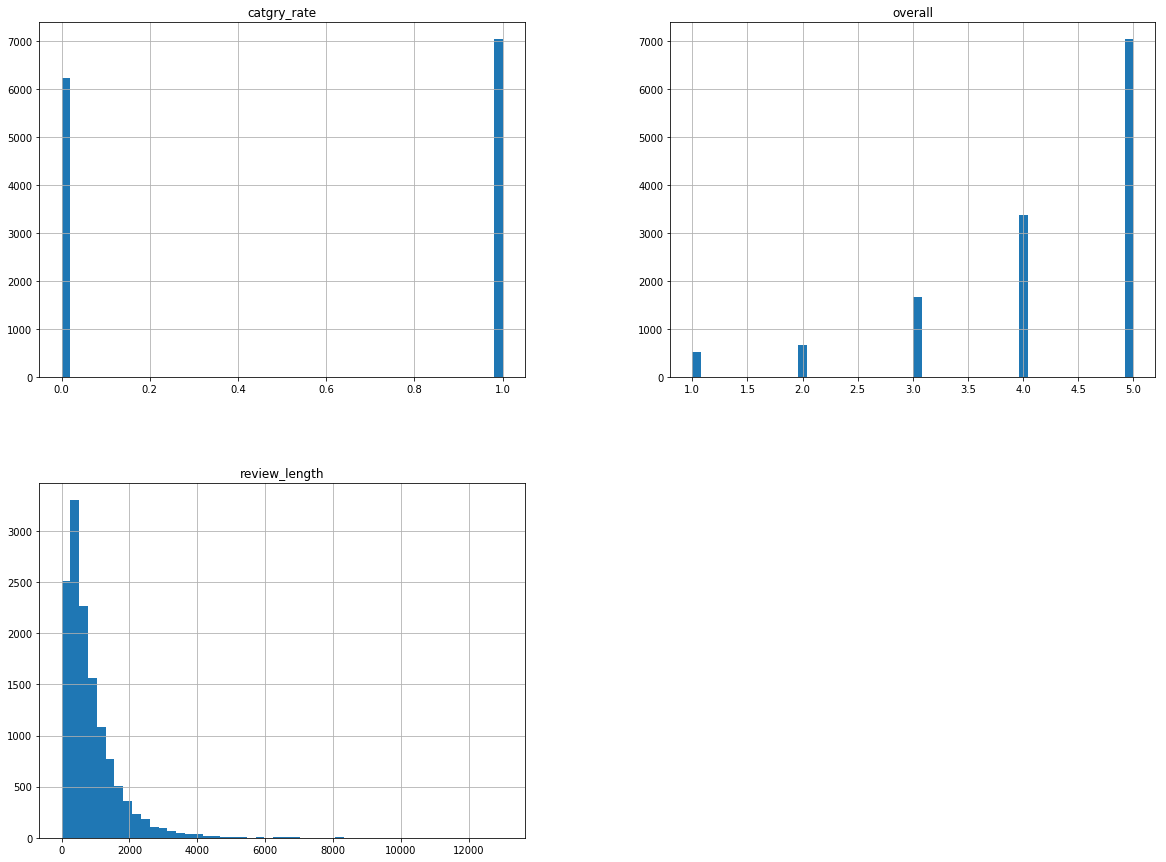

In [46]:
amazon.hist(bins=50,figsize=(20,15))
plt.show()

## Preprocessing
For the purposes of this project we will only use the 'reviewText' conlumn and process it using TfidVectorizor function from sklearn. There will be no other types of processing of the text. 

In [47]:
amazon['reviewText'] = amazon.reviewText.str.replace('[^\w\s]','')
amazon['reviewText'] = amazon.reviewText.str.split()


In [48]:
a=[]
for i in range(len(amazon.reviewText)):
    a.append(pd.Series(amazon.reviewText[i]).unique())

In [49]:
amazon['reviewText'] = a

In [50]:
 amazon['reviewText'] = amazon.reviewText.apply((' ,'.join))

In [51]:
for i in amazon.reviewText[:10]:
    print(type(i))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [52]:
amazon.reviewText[:1]

0    Good ,USA ,company ,that ,stands ,behind ,thei...
Name: reviewText, dtype: object

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
X= amazon.reviewText
Y= amazon.catgry_rate
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)

vectorizer = TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

#Applying the vectorizer
X_train_tfidf =vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test) 

In [54]:
# training set class sizes
y_train.value_counts()

1    5613
0    5004
Name: catgry_rate, dtype: int64

The features are fairly balance so we will keep them as they are unless the model is performing extremely poorly. 

# Modeling

### Naive Bayes

In [55]:
# Instatiate the model

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(fit_prior=True)
mnb.fit(X_train_tfidf , y_train)

y_pred = mnb.predict(X_test_tfidf) 

print('Accuracy score :',mnb.score( X_test_tfidf , y_test,))
print('ROC_AUC cross validataion score: ',cross_val_score(mnb, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))



# initiate GridsearchCV for best parameters
from sklearn.model_selection import GridSearchCV
param_grid = dict(alpha=np.arange(1,5,1),fit_prior=(True,False))
grid = GridSearchCV(mnb, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
grid.fit(X_train_tfidf , y_train)
print(grid.best_params_)
print(grid.best_score_)

# refit model with new prams
mnb = MultinomialNB(**grid.best_params_)
mnb.fit(X_train_tfidf , y_train)


y_pred = mnb.predict(X_test_tfidf) 
print(mnb.score( X_test_tfidf , y_test,))
print(cross_val_score(mnb, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Accuracy score : 0.7171374764595103
ROC_AUC cross validataion score:  [0.73029334 0.74240479 0.75414349 0.7830552  0.73766174]
{'alpha': 1, 'fit_prior': True}
0.7739424708229142
0.7171374764595103
[0.73029334 0.74240479 0.75414349 0.7830552  0.73766174]


### KNN

In [56]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(algorithm='auto', n_neighbors=10) 
neighbors.fit(X_train_tfidf, y_train)


print('Accuracy score :',neighbors.score( X_test_tfidf , y_test,))
print('ROC_AUC cross validataion score: ',cross_val_score(neighbors, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

# initiate GridsearchCV
param_grid = dict(weights=['distance','uniform'],n_neighbors=range(1,300,5))
grid = GridSearchCV(neighbors, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
grid.fit(X_train_tfidf , y_train)
print(grid.best_params_)
print(grid.best_score_)

# refit model with new params
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(**grid.best_params_)
neighbors.fit(X_train_tfidf, y_train)


print('Accuracy score :',neighbors.score( X_test_tfidf , y_test,))
print('ROC_AUC cross validataion score: ',cross_val_score(mnb, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Accuracy score : 0.5450094161958569
ROC_AUC cross validataion score:  [0.65212728 0.68622878 0.67628726 0.69215518 0.6741598 ]
{'n_neighbors': 296, 'weights': 'distance'}
0.7555062310386859
Accuracy score : 0.6998116760828625
ROC_AUC cross validataion score:  [0.73029334 0.74240479 0.75414349 0.7830552  0.73766174]


### Desision trees

In [57]:
from sklearn import tree
# Initialize and train decision tree.
decision_tree = tree.DecisionTreeClassifier(max_features= 'sqrt', random_state=20,)
decision_tree.fit(X_train_tfidf, y_train)
print('Accuracy score :',decision_tree.score( X_test_tfidf , y_test,))
print('ROC_AUC cross validataion score: ',cross_val_score(decision_tree, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))


# initiate GridsearchCV

param_grid = dict(max_depth=range(1,6,1), max_leaf_nodes=range(2,10,1), criterion=('gini','entropy'),
                  max_features=('sqrt',None,'log2'))
grid = GridSearchCV(decision_tree, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
grid.fit(X_train_tfidf, y_train)

print(grid.best_params_)
print(grid.best_score_)


# refit model with new params
decision_tree = tree.DecisionTreeClassifier(**grid.best_params_)
decision_tree.fit(X_train_tfidf, y_train)
print('Accuracy score :',decision_tree.score( X_test_tfidf , y_test,))

print('ROC_AUC cross validataion score: ',cross_val_score(decision_tree, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Accuracy score : 0.5657250470809793
ROC_AUC cross validataion score:  [0.55249663 0.55979889 0.56108258 0.53928113 0.51907993]
{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 8}
0.6227599961719562
Accuracy score : 0.60075329566855
ROC_AUC cross validataion score:  [0.61442574 0.64087149 0.63963771 0.58769077 0.5875272 ]


### Random forrest

In [58]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

# instantiate model
rfc = ensemble.RandomForestClassifier(n_estimators=10) 
rfc.fit(X_train_tfidf,y_train)
print('Accuracy score :',rfc.score( X_test_tfidf , y_test,))
print('ROC_AUC cross validataion score: ',cross_val_score(rfc, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))


# initiate GridsearchCV
param_grid = dict(max_depth=range(1,6,1), max_leaf_nodes=range(2,10,1))
grid = GridSearchCV(rfc, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
grid.fit(X_train_tfidf, y_train)

print(grid.best_params_)
print(grid.best_score_)

# refit model with new params
rfc = ensemble.RandomForestClassifier(**grid.best_params_) 
rfc.fit(X_train_tfidf, y_train)
print('Accuracy score :',rfc.score( X_test_tfidf , y_test,))
print('ROC_AUC cross validataion score: ',cross_val_score(rfc, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Accuracy score : 0.6150659133709981
ROC_AUC cross validataion score:  [0.6562611  0.57060334 0.62493938 0.63156468 0.61299811]
{'max_depth': 4, 'max_leaf_nodes': 8}
0.6271776806240738
Accuracy score : 0.5653483992467043


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC_AUC cross validataion score:  [0.52422047 0.55856511 0.57371987 0.60911425 0.54258989]


### Logistic regression

In [ ]:
# Declare a logistic regression classifier.
lr = LogisticRegression(random_state=20, fit_intercept=False ,solver='saga',max_iter=100, penalty='l1',C=1) 
 
# Fit the model.
fit = lr.fit(X_train_tfidf, y_train)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
y_pred = lr.predict(X_test_tfidf)

print('\n Accuracy by Motor vehicle theft')
print(pd.crosstab(y_test, y_pred))

print('\n Percentage accuracy: ',lr.score(X_test_tfidf, y_test)) 
print('ROC_AUC cross validataion score: ',cross_val_score(lr, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))


# initiate GridsearchCV
param_grid = dict(max_iter=range(8,15,1),class_weight=(None,'balanced'),C=np.arange(.1,4,.1))
grid = GridSearchCV(lr,param_grid, cv=3, scoring='roc_auc', return_train_score=True)
grid.fit(X_train_tfidf, y_train)
print(grid.best_params_)
print(grid.best_score_)


 
# refit the model with new params.
lr = LogisticRegression(**grid.best_params_) 
fit = lr.fit(X_train_tfidf, y_train)

# Display 
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
y_pred = lr.predict(X_test_tfidf)

print('\n Confusion Matrix')
print(pd.crosstab(y_pred, y_test))

print('\nAccuracy: ',lr.score(X_test_tfidf, y_test)) 
print('ROC_AUC cross validataion score: ',cross_val_score(lr, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Coefficients
[[0. 0. 0. ... 0. 0. 0.]]
[0.]

 Accuracy by Motor vehicle theft
col_0          0     1
catgry_rate           
0            842   389
1            405  1019

 Percentage accuracy:  0.7009416195856873
ROC_AUC cross validataion score:  [0.68510548 0.71664527 0.72789902 0.69512908 0.68166008]


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\keith\appdata\local\program

{'C': 3.9000000000000004, 'class_weight': 'balanced', 'max_iter': 8}
0.784372074761356
Coefficients
[[ 0.05161937  0.05161937 -0.26752677 ... -0.07232972 -0.07960326
   0.07550322]]
[0.34143499]

 Confusion Matrix
catgry_rate    0    1
row_0                
0            925  427
1            306  997

Accuracy:  0.7239171374764595


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC_AUC cross validataion score:  [0.75925847 0.75026387 0.78241335 0.78863215 0.74448929]


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### SVM

In [ ]:
from sklearn.svm import SVC
svc = SVC(gamma='auto',probability=True) 
svc.fit(X_train_tfidf,y_train)

# initiate GridsearchCV
param_grid = dict(C=np.arange(.1,5,.1))
grid = GridSearchCV(svc, param_grid, cv=3, scoring="roc_auc", return_train_score=True,n_jobs = -1)
grid.fit(X_train_tfidf, y_train)


print(grid.best_params_)
print(grid.best_score_ )

# refit model with new params
svc = SVC(**grid.best_params_) 
svc.fit(X_train_tfidf, y_train)


{'C': 0.7000000000000001}
0.7704369908669537


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.7000000000000001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Gradient boost

In [ ]:
from sklearn import ensemble 

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(n_estimators=500,max_depth=2,
                                          loss='deviance', random_state=20) 
clf.fit(X_train_tfidf, y_train)

# initiate GridsearchCV
param_grid = dict(max_depth=range(1,6,1), max_leaf_nodes=range(2,10,1))
grid = GridSearchCV(clf, param_grid, cv=3, scoring="f1", return_train_score=True)
grid.fit(X_train_tfidf, y_train)

print(grid.best_params_)
print(grid.best_score_)


# refit model with new params.
clf = ensemble.GradientBoostingClassifier(**grid.best_params_, random_state=20) 
clf.fit(X_train_tfidf, y_train)

In [ ]:
mnb_y_prob = cross_val_predict(mnb, X, y, method='predict_proba',cv=5)
knn_y_prob = cross_val_predict(neighbors, X, y, method='predict_proba',cv=5) 
tree_y_prob = cross_val_predict(decision_tree, X, y, method='predict_proba',cv=5) 
rfc_y_prob = cross_val_predict(rfc, X, y, method='predict_proba',cv=5) 
lr_y_prob = cross_val_predict(lr, X, y, method='predict_proba',cv=5) 
svc_y_prob = cross_val_predict(svc, X, y, method='predict_proba',cv=5) 
clf_y_prob = cross_val_predict(clf, X, y, method='predict_proba',cv=5) 

In [ ]:
mnb_y_pred = mnb.predict(X_test_tfidf)
knn_y_pred = neighbors.predict(X_test_tfidf)
tree_y_pred = decision_tree.predict(X_test_tfidf)
rfc_y_pred = ref.predict(X_test_tfidf)
lr_y_pred = lr.predict(X_test_tfidf)
svc_y_pred = svc.predict(X_test_tfidf)
clf_y_pred = clf.predict(X_test_tfidf)

In [103]:
models = [mnb, neighbors, decision_tree, rfc, lr, svc, clf]

In [ ]:
for model in models:
    

AUC: 0.749
AUC: 0.675
AUC: 0.623
AUC: 0.704


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packa

AUC: 0.696
AUC: 0.760
AUC: 0.717


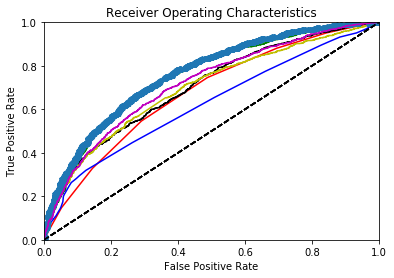

In [102]:
AUC_ROC_plot(mnb,X_test_tfidf,y_test,'g')
AUC_ROC_plot(neighbors,X_test_tfidf,y_test,'r')
AUC_ROC_plot(decision_tree,X_test_tfidf,y_test,'b')
AUC_ROC_plot(rfc,X_test_tfidf,y_test,'k')
AUC_ROC_plot(lr,X_test_tfidf,y_test,'y')
AUC_ROC_plot(svc,X_test_tfidf,y_test,'p')
AUC_ROC_plot(clf,X_test_tfidf,y_test,'m')

AUC: 0.749
AUC: 0.760


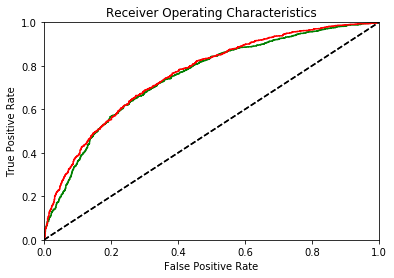

In [105]:
AUC_ROC_plot(mnb,X_test_tfidf,y_test,'g')
AUC_ROC_plot(svc,X_test_tfidf,y_test,'r')

In [ ]:
# Function that prints AUC and plots ROC curve
def AUC_ROC_plot(model,X,y,color): 
    y_prob = cross_val_predict(model, X, y, method='predict_proba',cv=5)    
    auc = roc_auc_score(y,y_prob[:,1])
    print('AUC: %.3f' % auc)
    fpr, tpr,thresholds = roc_curve(y,y_prob[:,1])
    plt.plot(fpr,tpr,color)    
    plt.plot([0.0,1.0],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics')
    plt.xlim([0.0,1.0])     
    plt.ylim([0.0,1.0])
AUC_ROC_plot(mnb,X_test_tfidf,y_test,'g')

In [ ]:
# fuction for prcision recall plot 
def precision_recall_plot (model,X,y):
    y_prob = cross_val_predict(model, X, y, method='predict_proba',cv=10)
    precisions, recalls,thresholds=precision_recall_curve(y, y_prob[:,1])
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.title('Precision-Recall vs Threshold')
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.ylim([0,1])
precision_recall_plot (mnb,X_test_tfidf,y_test) 
plt.show()
 
